In [38]:
import numpy as np
import random
import matplotlib.pyplot as plt

random.seed(111)
np.random.seed(111)

# Formulations of Vector Autoregression

The standard definition of a the autoregressive model VAR($p$) is:


$$
    \bm{y}_t = \bm{\nu} + A_1 \bm{y}_{t-1} + \cdots + A_p \bm{y}_{t-p} + \bm{u}_t \quad (1)
$$

where $t \in \mathbb{Z}$, $\bm{y}$ is a length $K$ random vector,
$\bm{\nu}$ is a fixed length $K$ vector, the $A_i$ are $K \times K$
constant coefficient matrices and $\bm{u}_t$ is a white noise
or innovation process with $E(\bm{u}_t) = \bm{0}$, 
$E(\bm{u}_t \bm{u}_t^T) = \Sigma_{\bm{u}}$ with 
$\Sigma_{\bm{u}}$ assumed non-singular, and 
$E(\bm{u}_t \bm{u}_s^T) = \bm{0}$ when $s \neq t$.

Since every VAR($p$) process can be expressed as a VAR(1) process, we will simplify the above expression.

$$
\bm{y}_t = \bm{\nu} + A \bm{y}_{t-1} + \bm{u}_t
$$

We can simulate this system by providing an initial condition $\bm{y}_0$, then at each timestep, taking a draw from a multivariate normal distribution to simulate a realization of $\bm{u}_t$.

We can also derive an alternate formulation by applying this expression to itself recursively.

$$
\bm{y}_t = \bm{\nu} + A \bm{y}_{t-1} + \bm{u}_t \\
\bm{y}_t = \bm{\nu} + A \big(\bm{\nu} + A \bm{y}_{t-2} + \bm{u}_{t-1} \big) + \bm{u}_t \\
\vdots \\
\bm{y}_t = (I + A + A^2 + \cdots + A^m) \bm{\nu} + A^{m+1} \bm{y}_{t - (m+1)} + \sum_{i = 0}^m A^i \, \bm{u}_{t - i}.


$$

If the modulus of the largest eigenvalue of $A$ is less than one, then $||A^m|| \rightarrow 0$ as $m \rightarrow \infty$ so $A^{m+1}y_{t - (m+1)} \rightarrow 0$ and the series 
$$
I + A + A^2 + \cdots = (I - A)^{-1}
$$

Thus we have
$$
\bm{y}_t = \bm{\mu} + \sum_{i=0}^{\infty}A^i \bm{u}_{t - i} \quad (2)
$$

where $\bm{\mu} = (I - A)^{-1}\bm{\nu}$.

To better understand how these formulations work and what they mean, we will attempt to show how the different formulations produce the same time series.

We will approximate $\bm{y}_t$ with $\hat{\bm{y}}_t$
$$
\hat{\bm{y}}_t = \bm{\mu} + \sum_{i=0}^{M}A^i\bm{u}_{t-i} \\
\hat{\bm{y}}_t = \bm{\mu} + \bm{u}_t + A \bm{u}_{t - 1} + \cdots + A^{(M)} \bm{u}_{t-M}
$$

To compute $\hat{\bm{y}}_t$ we need the a sequence of realizations of $\bm{u}_t$, $\bm{u}_{t-1}$, ..., $\bm{u}_{t-M}$. We can aquire this by sampling from a multivariate normal with zero mean and covariance $\Sigma_{\bm{u}}$

Since 
$$\hat{\bm{y}}_{t+1} = \bm{\mu} + \bm{u}_{t+1} + A \bm{u}_{t} + \cdots + A^{(M)} \bm{u}_{t+1 -M},
$$
it depends on all terms of the previous sequence $\bm{u}_t$, $\bm{u}_{t-1}$, ..., $\bm{u}_{t + 1- M}$, $\bm{u}_{t-M}$ except the last, $\bm{u}_{t-M}$. 

It also requires one new value to be generated: $\bm{u}_{t+1}$.

Thus, after generating the first $M$ random vectors, we can proceed by only generating one random vector each iteration.

## Simulating with Formulation (2)

In [53]:
highest_power_of_A = 12
print(f"||A||^(max_power) approx equal to {desired_spect_rad**highest_power_of_A}")

||A||^(max_power) approx equal to 4.096000000000002e-09


#### Function for Simulation

In [54]:
def rescale_spec_rad(A, desired_spect_rad):
    # Rescale the largest eigenvalue of A so `spec_rad(A)== desired_spect_rad`
    spect_rad = np.max(np.abs(np.linalg.eigvals(A)))
    scaledA = A * desired_spect_rad / spect_rad
    return scaledA

def var_sim_form2(mu, A, cov, max_A_pow=15, timesteps=200):

    process_dim = A.shape[0]
    zero_mean = np.zeros(process_dim)

    # To store the timeseries
    y = np.zeros((process_dim, timesteps))

    # To store powers of A
    Apows = [np.eye(process_dim)]

    # To store white noise
    white_noise_vecs = [np.random.multivariate_normal(zero_mean, cov)]

    # Initialized powers of A and white noise vectors
    for i in range(max_A_pow):
        Apows.append(A @ Apows[-1])
        white_noise_vecs.append(np.random.multivariate_normal(zero_mean, cov))
    
    # Simulate timesteps
    for t in range(timesteps):
        # Grab the `max_A_pow + 1` most recent noise vectors
        noise_vec_reverse = white_noise_vecs[:max_A_pow:-1]
        # Weight them by the appropriate powers of A
        weighted_noise = [Ai @ u for Ai, u in zip(Apows, noise_vec_reverse)]
        # Sum them all together
        weighted_noise_sum = np.sum(weighted_noise, axis=0)
        # Assign to y_t
        y[:, t] = mu + weighted_noise_sum
        # New white noise vector
        white_noise_vecs.append(np.random.multivariate_normal(zero_mean, cov))


    return y, white_noise_vecs

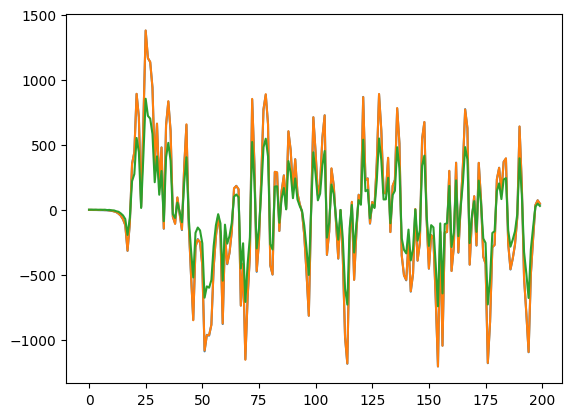

In [55]:
A = np.array([
    [0.0, 1.0, 1.0],
    [1.0, 0.0, 1.0],
    [0.0, 1.0, 0.0],
])
# Desired spectral radius of A (largest eigenvalue modulus)
desired_spect_rad = .2
A = 



# mu vector
mu = np.array([0.0, 1, 2])

# nu vector
nu = (np.eye(A.shape[0]) + A)

# Covariance of white noise
cov = .2 * np.array([
    [1., 0.0, 0.0],
    [0.0,  1., 0.0],
    [0.0, 0.0, 1.0],
])


Y, U = var_sim_form2(mu, A, cov)
plt.plot(Y.T)